#Aplicación de spectral clustering a datos con estructura de grafos

En NLP, muchas veces los datos con los que se trabaja tienen una esgructura de grafo (por ejemplo, redes léxicas, paradigmas verbales, etc.) El modelo de spectral clustering puede adaptarse a esta estructura y crear clusters de los nodos. A continuación presentamos una aplicación a un grafo de datos bilingües.

In [0]:
#Importamos los paquetes que vamos a utilizar
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from scipy.linalg import eig
from csv import reader
from operator import itemgetter
from sklearn.decomposition import PCA

## Preprocesamiento de los datos

Cuando trabajamos con datos ya en estructura de grafos, el preprocesamiento se vuelve más simple, pues no requerimos generar esta estructura. En este caso, en lugar de tener una secuencia de pasos Vector - Grafo - Vector, nos saltaremos el primer paso y sólo tendremos los pasos Grafo - Vector.


In [0]:
#Montamos el contenido de Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Abrimos el archivo
file = open('/content/drive/My Drive/Curso RIIAA/data/corpus_bilingual.txt','r')
print(file)

<_io.TextIOWrapper name='/content/drive/My Drive/Curso RIIAA/corpus_bilingual.txt' mode='r' encoding='UTF-8'>


In [0]:
#Leemos el archivo
edges = list(reader(file, delimiter='\t'))

Los datos se encuentran estructurados en un grafo bipartito, donde un conjunto de nodos corresponde al lenguaje Náhuatl y otro al Español. Como existen préstamos entre una y otra lengua, utilizaremos un índice para diferenciar a que lengua corresponde cada forma léxica.

In [0]:
#Creamos las aristas que definen el grafo
edges = [(edge[0]+'_NA',edge[1]+'_ES',float(edge[4])/38608) for edge in edges] #Dividir entre el máximo (38608) normaliza los pesos
print(edges)

[('obispo_NA', 'obispo_ES', 1.0), ('juan_NA', 'juan_ES', 0.8993990882718608), ('xochitl_NA', 'flor_ES', 0.6932760049730626), ('ilhuicac_NA', 'cielo_ES', 0.6168410692084542), ('juan di ego_NA', 'juan diego_ES', 0.43703377538334026), ('nanquili_NA', 'responder_ES', 0.3665302527973477), ('xoco youh_NA', 'hijo_ES', 0.33915250725238294), ('di ego_NA', 'diego_ES', 0.2840084956485702), ('tlatelol_NA', 'tlatelolco_ES', 0.26673228346456695), ('celia mimiliuhi_NA', 'rozagante medrar_ES', 0.2596094073767095), ('cuiccanimetl_NA', 'cantor_ES', 0.2590395772896809), ('yacac_NA', 'tepeyac_ES', 0.24992229589722337), ('teocal_NA', 'templo_ES', 0.2120285951098218), ('ni_NA', 'yo_ES', 0.21164007459593867), ('juan_NA', 'juan diego_ES', 0.1991815167840862), ('icpac_NA', 'cerro_ES', 0.18257874015748032), ('ilhuicac zihuapilli_NA', 'cielo_ES', 0.18234562784915043), ('ticuiccanitl_NA', 'poeta_ES', 0.17447161210111894), ('auh_NA', 'y_ES', 0.1717778698715292), ('no_NA', 'mi_ES', 0.1533360961458765), ('ego_NA', '

Podemos visualizar los datos a aprtir de la librería de $networkx$. Esta misma librería nos puede facilitar la creación de la matriz de adyacencia.

[('obispo_NA', 'obispo_ES', {'weight': 1.0}), ('juan_NA', 'juan_ES', {'weight': 0.8993990882718608}), ('xochitl_NA', 'flor_ES', {'weight': 0.6932760049730626}), ('ilhuicac_NA', 'cielo_ES', {'weight': 0.6168410692084542}), ('juan di ego_NA', 'juan diego_ES', {'weight': 0.43703377538334026}), ('nanquili_NA', 'responder_ES', {'weight': 0.3665302527973477}), ('xoco youh_NA', 'hijo_ES', {'weight': 0.33915250725238294}), ('di ego_NA', 'diego_ES', {'weight': 0.2840084956485702}), ('tlatelol_NA', 'tlatelolco_ES', {'weight': 0.26673228346456695}), ('celia mimiliuhi_NA', 'rozagante medrar_ES', {'weight': 0.2596094073767095})]


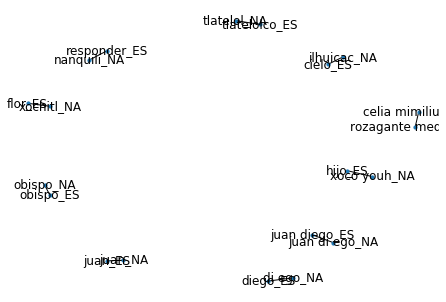

In [0]:
#Creamos un grafo a partir de las aristas que hemos definido
G = nx.Graph()
G.add_weighted_edges_from(edges[:10])    #Tomamos pocas aristas para que sea más fácil su visualización

#Visualización de las aristas en formato networkx
print(G.edges(data=True))
#Dibuja el grafo
nx.draw(G, with_labels=True, node_size=10)

## Aplicación del algoritmo de spectral clustering

Una vez que tenemos los datos en un formato de grafo tratable, podemos pasar a aplicar el alforitmo de spectral clustering. Para esto, obtenemos la matriz de adyacencia.

In [0]:
#Obtiene la matriz de adyacencia a partir del formato netowrkx
A = nx.to_numpy_array(G)

#Guarda las etiqeutas de los nodos
labels = G.nodes

#Visualiza la matriz de adyacencia
df = pd.DataFrame(A, index=labels, columns=labels)
print(df.to_string())

                     obispo_NA  obispo_ES   juan_NA   juan_ES  xochitl_NA   flor_ES  ilhuicac_NA  cielo_ES  juan di ego_NA  juan diego_ES  nanquili_NA  responder_ES  xoco youh_NA   hijo_ES  di ego_NA  diego_ES  tlatelol_NA  tlatelolco_ES  celia mimiliuhi_NA  rozagante medrar_ES
obispo_NA                  0.0        1.0  0.000000  0.000000    0.000000  0.000000     0.000000  0.000000        0.000000       0.000000      0.00000       0.00000      0.000000  0.000000   0.000000  0.000000     0.000000       0.000000            0.000000             0.000000
obispo_ES                  1.0        0.0  0.000000  0.000000    0.000000  0.000000     0.000000  0.000000        0.000000       0.000000      0.00000       0.00000      0.000000  0.000000   0.000000  0.000000     0.000000       0.000000            0.000000             0.000000
juan_NA                    0.0        0.0  0.000000  0.899399    0.000000  0.000000     0.000000  0.000000        0.000000       0.000000      0.00000       0.0000

Ya que la matriz de adyacencia guarda información del grafo en formato vectorial, podemos visualizarla en un espacio $\mathbb{R}^d$. Sin embargo, notamos que ésta no nos da suficiente información para clusterizar los puntos.

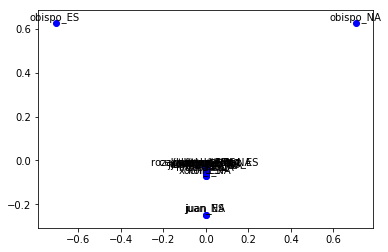

In [0]:
#Función para plotear
def plot_words(Z,ids,color='blue'):
    #Reduce a dos dimensiones con PCA
    Z = PCA(n_components=2).fit_transform(Z)
    r=0
    #Plotea las dimensiones
    plt.scatter(Z[:,0],Z[:,1], marker='o', c=color)
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        #Agrega las etiquetas
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
        
plot_words(A,labels)
plt.show()

Por tanto, aplicamos spectral clustering, obteniendo la matriz laplaciana como: $L = D - A$, donde $D$ es la matriz de grado y $A$ la de adyacencia. Posteriormente hacemos la factorización espectral.

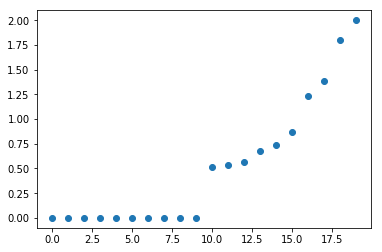

In [0]:
#Se calcula la matriz Laplaciana
L = np.diag(A.sum(0))-A

#Se calculan los eigen valores y eigen vectores de L
eig_vals, eig_vecs = eig(L)

#Se ordenan con respecto a los eigenvalores
values = sorted(zip(eig_vals.real,eig_vecs), key=itemgetter(0))

#Obtenemos ambos eigens
vals, vecs = zip(*values)

#Se crea una matriz de eigenvectores
matrix = np.array(vecs)

#Visualización de eigenvalores
plt.plot(np.array(vals),'o')
plt.show()

Finalmnete, obtenemos los nuevos vectores a partir de los eigenvectores de $L$ asociados a los eigenvalores más pequeños.

(20, 20)


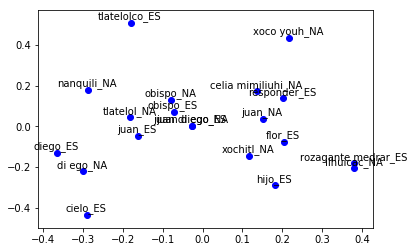

In [0]:
#Obtiene la matriz con los vectores nuevos
M_hat = matrix.T.real #Se toman todos los eigenvectores

#Tamaño de la matriz
print(M_hat.shape)
#Ploteamos los datos nuevos
plot_words(M_hat,labels)

### Clustering de los puntos

Una vez obtenido los nuevos vectores, podemos aplicar un método de clustering (k-means) para observar las regularidades encontradas.

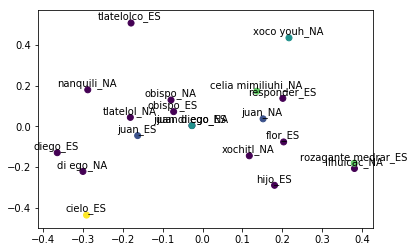

In [0]:
from sklearn.cluster import KMeans

#Número de centroides
centroids=5
#Aplicación de kmenas
kmeans = KMeans(n_clusters=centroids, init='random').fit(M_hat)

#Obtención de los clusters
pred_lables = kmeans.predict(M_hat)

#Plot de clusters
plot_words(M_hat, labels, color=pred_lables)
plt.show()